# HW3-B. Defining an Encoder-Decoder model

## About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (06/03/2024)

**Requirements:**
- Python 3
- Matplotlib
- Numpy
- Pandas
- Torch
- Torchmetrics

In [28]:
!pip install matplotlib
!pip install numpy
!pip install torch torchvision
!pip install pandas

In [29]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/DeepLearningHW3/HW3_updated')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pandas
import pandas as pd
# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# Helper functions (additional file)
from helper_functions import *

<div class="alert alert-block alert-info">
<b>An important note: While usually not advised, you might want to run the code for this homework using CPU only. <br>
It remains possible, however, to use GPU, but we would advise against it, until we have been able to clarify the reason for bugs (most likely some CUDA reason). </b>
</div>

In [31]:
# Use GPU if available, else use CPU
device = torch.device("cpu")
print(device)

# # Use GPU if available, else use CPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

cpu


## 0. Dataset and Dataloaders from earlier

We start by loading our dataset from the Excel file, and reuse our Dataset and Dataloader objects from HW3-A.

In [32]:
# Load dataset from file
excel_file_path = '/content/drive/MyDrive/DeepLearningHW3/HW3_updated/dataset.xlsx'
times, values = load_dataset(excel_file_path)

In [33]:
class CustomDataset(Dataset):
    def __init__(self, times, values, n_inputs, n_outputs):
        self.times = times
        self.values = values
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.define_samples()

    def define_samples(self):
        self.inputs = []
        self.outputs = []
        self.mid = []
        # Define all inputs
        for i in range(len(times) - self.n_inputs - self.n_outputs + 1):
            # Last input not included (only 19 values)
            next_input = self.values[i:(i + self.n_inputs - 1)]
            next_output = self.values[(i + self.n_inputs):(i + self.n_inputs + self.n_outputs)]
            # Mid is the turning point, i.e. the value of the 20-th sample in the series of inputs
            # It will not be read by the encoder and will serve as the first input to the decoder
            next_mid = [self.values[i + self.n_inputs - 1]]
            self.inputs.append(next_input)
            self.outputs.append(next_output)
            self.mid.append(next_mid)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        # Select samples corresponding to the different inputs
        # and outputs we have created with the define_samples() function,
        # and convert them to PyTorch tensors
        x = torch.tensor(self.inputs[idx], dtype = torch.float32)
        y = torch.tensor(self.outputs[idx], dtype = torch.float32)
        m = torch.tensor(self.mid[idx], dtype = torch.float32)
        return x, y, m

In [34]:
# Create our PyTorch Dataset object from the class above
n_inputs = 20
n_outputs = 5
pt_dataset = CustomDataset(times, values, n_inputs, n_outputs)

In [35]:
# Create DataLoader object
batch_size = 256
pt_dataloader = DataLoader(pt_dataset, batch_size = batch_size, shuffle = True)
print(pt_dataloader)

## 1. Step 1: Designing an Encoder model

We propose to approach this task, by using and Encoder-Decoder model of some sort. Both the Encoder and Decoder parts of the model will consist of a simple LSTM.

**Question 6:** What is a Seq2Seq model, and how does it relate to Encoder-Decoder models?





We want to implement the LSTM architecture drawn below. It objective is to receives entires $ x(t), x(t+1), ..., x(t+18) $, 19 input points, and learn the dynamics of the data, in the hopes that we will later be able to use this information for future predictions.

<img title="Our Encoder Architecture" alt="Our Encoder Architecture" src="./images/20240318_183921.jpg">

Given the LSTM Architecture above, answer the questions below.

**Question 7:** This encoder seems to receive all inputs present in the first tensor coming from the Dataloader object, which includes n_inputs - 1 elements (here 20-1 = 19 inputs). This LSTM could then produce 19 outputs, but for some reason, they are not shown on this image. What is the reason for this omission? Why is our diagram suggesting that the final memory vector is the only important information that will come out of this encoder model?



**Question 8:** There are a few Nones to be replaced in the code below. Please show your code in your report after you have figured out the correct EncoderRNN class.

In [36]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size -1 , hidden_size)

    def forward(self, inputs):

        output, hidden = self.lstm(inputs)


        return hidden


In [37]:
# Defining our EncoderRNN model
hidden_size = 25
encoder_model = EncoderRNN(n_inputs, hidden_size).to(device)
print(encoder_model)

EncoderRNN(
  (lstm): LSTM(19, 25)
)


**Question 9:** Consider the cell below. What is contained in *vec1\[0\]* and *vec2\[0\]*?




In [38]:
# Testing our EncoderRNN model
inputs, _, _ = next(iter(pt_dataloader))
inputs_reworked = inputs[0, :].reshape(1, -1)
print(inputs_reworked.shape)
encoder_out = encoder_model(inputs_reworked)
# print(encoder_out[1].shape)
vec1, vec2 = encoder_out
print(vec1[0])
print(vec2[0])

torch.Size([1, 19])
tensor([ 7.4241e-01, -6.9378e-01,  1.6525e-08,  1.0453e-14,  7.6156e-01,
        -3.0093e-02, -2.1321e-02,  2.0442e-01,  1.7446e-06,  6.7108e-11,
         1.4315e-02,  6.3719e-10, -2.5761e-07, -7.6150e-01, -6.2333e-01,
        -7.6023e-01,  4.3926e-03, -4.4195e-02, -7.5313e-08,  1.6478e-08,
        -7.6084e-01,  7.6156e-01, -3.3546e-04,  1.2357e-12, -7.6111e-01],
       grad_fn=<SelectBackward0>)
tensor([ 9.5582e-01, -8.5525e-01,  9.8688e-01,  9.9999e-01,  9.9992e-01,
        -1.0000e+00, -7.4375e-02,  2.0827e-01,  1.3280e-04,  3.4446e-06,
         1.4316e-02,  2.2344e-07, -2.3082e-06, -9.9979e-01, -7.5817e-01,
        -9.9861e-01,  4.4012e-03, -4.4227e-02, -5.3499e-01,  9.9928e-01,
        -9.9863e-01,  9.9993e-01, -3.4297e-04,  1.4651e-09, -9.9885e-01],
       grad_fn=<SelectBackward0>)


## 2. Step 2: Designing a Decoder model

Our next step is to produce a decoder model. It will receive a certain memory vector as its memory starting point. It will also receive five inputs denoted *val1*, *val2*, *val3*, *val4*, and *val5*. It will then attempt to produce five outputs denoted *y1*, *y2*, *y3*, *y4*, and *y5*.

Consider the architecture drawn below and answer the following questions.

As you can see, it will receive certain input values *valk* and will attempt to predict a value *yk*, with k in $ \{1, 2, 3, 4, 5\} $.

<img title="Our Decoder Architecture" alt="Our Decoder Architecture" src="./images/20240318_184112.jpg">

**Question 10:** Assuming that the encoder has seen the inputs $ x(t), x(t+1), ... x(t+18) $, what should we use as a memory vector to play the role of the memory starting point for the decoder?

**Question 11:** We will use a Decoder that is NOT auto-regressive. What does that mean for the input and output values of our Decoder LSTM-based model?

**Question 12:** Assuming that the encoder has seen the inputs corresponding to the sample with index $ t $, i.e. $ x(t), x(t+1), ... x(t+18) $, which values should we use in place fo *val1*, *val2*, *val3*, *val4*, *val5*? Remember Q11, we are not planning to use an auto-regressive decoder here. Could you then explain why we only used 19 values as inputs in the encoder part then?

**Question 13:** Assuming that the encoder has seen the inputs corresponding to the sample with index $ t $, i.e. $ x(t), x(t+1), ... x(t+18) $, what are the target values should we are trying to match with our predictions in place fo *y1*, *y2*, *y3*, *y4*, *y5*?

**Question 14:** What is then the purpose and the expected use for the Linear layer in self.linear? Why is there a for loop in the forward method?

**Question 15:** Having figured out the questions in Q10-14, can you figure what to use in place of the Nones in the code for the DecoderRNN below? Show your final code in your report.

In [39]:



class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTM(1, hidden_size)
        self.linear = nn.Linear(hidden_size, 1)


    def forward(self, outputs, mid, encoder_hidden_states):
        hidden_states = encoder_hidden_states
        final_pred = torch.zeros(outputs.shape).to(outputs.device)
        val = mid
        for i in range(outputs.shape[1]):
            pred, hidden_states = self.lstm(val, hidden_states)
            pred = self.linear(pred)
            final_pred[:, i] = pred.squeeze()
            val = outputs[:, i:i+1]
        return final_pred



In [40]:
# Defining our DecoderRNN model
decoder_model = DecoderRNN(hidden_size = hidden_size, output_size = n_outputs)
print(decoder_model)

DecoderRNN(
  (lstm): LSTM(1, 25)
  (linear): Linear(in_features=25, out_features=1, bias=True)
)


**Question 16:** Consider the cell below. What should the final size of the *decoder_out* tensor be?

In [41]:
# Testing our DecoderRNN model
inputs, outputs, mid = next(iter(pt_dataloader))
print(outputs.shape)
encoder_out = encoder_model(inputs)
decoder_out = decoder_model(outputs, mid, encoder_out)
print(decoder_out.shape)

torch.Size([256, 5])
torch.Size([256, 5])


## Step 3: Assembling everything into a Seq2Seq model.

Our final objective is to assemble both our encoder model and decoder model into a Seq2Seq model, following the architecture drawn below.

<img title="Our Seq2Seq Architecture" alt="Our Seq2Seq Architecture" src="./images/20240318_184350.jpg">

**Question 17:** Why have we prefered to use a Decoder-Encoder architecture, instead of a single LSTM that would receive 24 inputs, produce 24 outputs, and would only compare the final 5 predicted values to the ground truth in our dataset?

**Question 18:** Having figured out the models in EncoderRNN and DecoderRNN, can you now figure out the missing code in the cell below? Show it in your report.

In [42]:
class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Seq2Seq, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encoder_model = EncoderRNN(self.input_size, self.hidden_size)
        self.decoder_model = DecoderRNN(self.hidden_size, self.output_size)

    def forward(self, inputs, outputs, mid):
        encoder_hidden_states = self.encoder_model(inputs)
        pred_final = self.decoder_model(outputs, mid, encoder_hidden_states)
        return pred_final

In [43]:
# Defining our Seq2Seq model
seq2seq_model = Seq2Seq(input_size = n_inputs, \
                        hidden_size = hidden_size, \
                        output_size = n_outputs)
print(seq2seq_model)

Seq2Seq(
  (encoder_model): EncoderRNN(
    (lstm): LSTM(19, 25)
  )
  (decoder_model): DecoderRNN(
    (lstm): LSTM(1, 25)
    (linear): Linear(in_features=25, out_features=1, bias=True)
  )
)


In [44]:
# Testing our Seq2Seq model
seq2seq_model = Seq2Seq(input_size = n_inputs, \
                        hidden_size = hidden_size, \
                        output_size = n_outputs)
inputs, outputs, mid = next(iter(pt_dataloader))
print(inputs.shape, outputs.shape, mid.shape)
seq2seq_out = seq2seq_model(inputs, outputs, mid)
print(seq2seq_out.shape)

torch.Size([256, 19]) torch.Size([256, 5]) torch.Size([256, 1])
torch.Size([256, 5])


## Step 4: Finally, training and evaluating our Seq2Seq model

**Question 19:** Given your understanding of the task, which (very simple) loss function should we use in our trainer function? Show your updated code in your report.

In [45]:
def train(dataloader, model, num_epochs, learning_rate):
    # Set the model to training mode
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, outputs, mid in dataloader:
            # Clear previous gradients
            optimizer.zero_grad()
            # Forward pass
            pred = model(inputs, outputs, mid)
            # Calculate loss
            loss = criterion(pred, outputs)
            total_loss += loss.item()
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Print total loss every few epochs
        if epoch % 25 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Avg Loss: {total_loss/len(dataloader)}')

Having figure out the correct models and trainer function, you may not use the celml below. It will train the model from scratch, on 50 iterations and will show you the amount of time take to train this model. This is just information to let you know how long the full training loop (in the next cell), might take on your machine!

In [46]:
# Training the model
hidden_size = 25
seq2seq_model = Seq2Seq(input_size = n_inputs, \
                        hidden_size = hidden_size, \
                        output_size = n_outputs).to(device)
%timeit -r 1 -n 1 train(dataloader = pt_dataloader, model = seq2seq_model, num_epochs = 26, learning_rate = 1e-3)

Epoch 1/26, Avg Loss: 1922.5652160644531
Epoch 26/26, Avg Loss: 1080.428123474121
18.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [47]:
# This was used to save a starting point for the next cell, do not run.
#torch.save(seq2seq_model.state_dict(), 'seq2seq_model_start.pth')

**Question 20:** It seems the loss values we are seeing when using the model with randomly initialized parameters is very high. While it seems to decrease, it seems lots of iterations will be needed. The next cell suggests to run the training loop, but initialize the weights of the model using values in the *seq2seq_model_start.pth* file, presumably coming from another roughly similar model, trained on a different but similar task. This is done in an attempt to help the model train better and faster. Under which name is this concept known in Deep Learning?

<div class="alert alert-block alert-info">
<b>Note: The next cell will take a (somewhat) long time to run. On my machine CPU, it takes ~4minutes.<br>
You can simply guess how long it will take to run on your machine, by using the execution time of the previous cell (using 50 iterations) and multiplying that by 20. As mentioned at the beginning of this Notebook, we have observed issues in running the code, on some CUDA machines. It is unclear at the moment, so try GPU computing at your own risk... </b>
</div>

In [65]:
# Training the model
hidden_size = 25
seq2seq_model = Seq2Seq(input_size = n_inputs, \
                        hidden_size = hidden_size, \
                        output_size = n_outputs).to(device)
# Start from given parameters to make training easier
# seq2seq_model.load_state_dict(torch.load('/content/drive/MyDrive/DeepLearningHW3/HW3_updated/seq2seq_model_start.pth'))
%timeit -r 1 -n 1 train(dataloader = pt_dataloader, model = seq2seq_model, num_epochs = 1051, learning_rate = 1e-3)

Epoch 1/1051, Avg Loss: 1918.3307495117188
Epoch 26/1051, Avg Loss: 1099.5313148498535
Epoch 51/1051, Avg Loss: 736.6941795349121
Epoch 76/1051, Avg Loss: 496.3246784210205
Epoch 101/1051, Avg Loss: 331.27686500549316
Epoch 126/1051, Avg Loss: 217.67234325408936
Epoch 151/1051, Avg Loss: 142.6161904335022
Epoch 176/1051, Avg Loss: 92.27700614929199
Epoch 201/1051, Avg Loss: 60.493889808654785
Epoch 226/1051, Avg Loss: 39.3471097946167
Epoch 251/1051, Avg Loss: 25.106982469558716
Epoch 276/1051, Avg Loss: 15.722241044044495
Epoch 301/1051, Avg Loss: 9.661194175481796
Epoch 326/1051, Avg Loss: 5.815572768449783
Epoch 351/1051, Avg Loss: 3.4536017924547195
Epoch 376/1051, Avg Loss: 2.049138516187668
Epoch 401/1051, Avg Loss: 1.261725541204214
Epoch 426/1051, Avg Loss: 0.8151983730494976
Epoch 451/1051, Avg Loss: 0.5498316548764706
Epoch 476/1051, Avg Loss: 0.39846478682011366
Epoch 501/1051, Avg Loss: 0.30787113308906555
Epoch 526/1051, Avg Loss: 0.2415805896744132
Epoch 551/1051, Avg Los

In [50]:
# Do not uncomment and execute, this was used to prepare the model that you will be using in the final question!
#torch.save(seq2seq_model.state_dict(), 'seq2seq_model_end.pth')

**Question 21:** The code below shows the predictions produced by your Seq2Seq model after training and can be used to confirm that you have trained the right model! Show some screenshots in your report, and discuss the final performance you have obtained for your model. For your information, I typically obtain an MSE of ~0.05 after 1000 iterations of training. Additional performance can probably be obtained via hyperparameters tuning (changing the size of memory vector, etc.).

In [66]:
# Quick check on our Seq2Seq model
# (Seeding for reproducibility)
# hidden_size = 25
# seq2seq_model = Seq2Seq(input_size = n_inputs, \
#                         hidden_size = hidden_size, \
#                         output_size = n_outputs).to(device)
# seq2seq_model.load_state_dict(torch.load('seq2seq_model_end.pth'))
seed_value = 187
test_model(seq2seq_model, pt_dataloader, seed_value)

Ground truth:  tensor([24.6567, 24.7942, 24.8445, 24.9499, 25.1038])
Prediction:  tensor([24.5019, 24.6671, 24.8061, 24.8588, 24.9641], grad_fn=<SliceBackward0>)
Mean Square Error for Sample:  0.013886986


[53.231678 53.17655  53.454716 53.695442 53.233242]


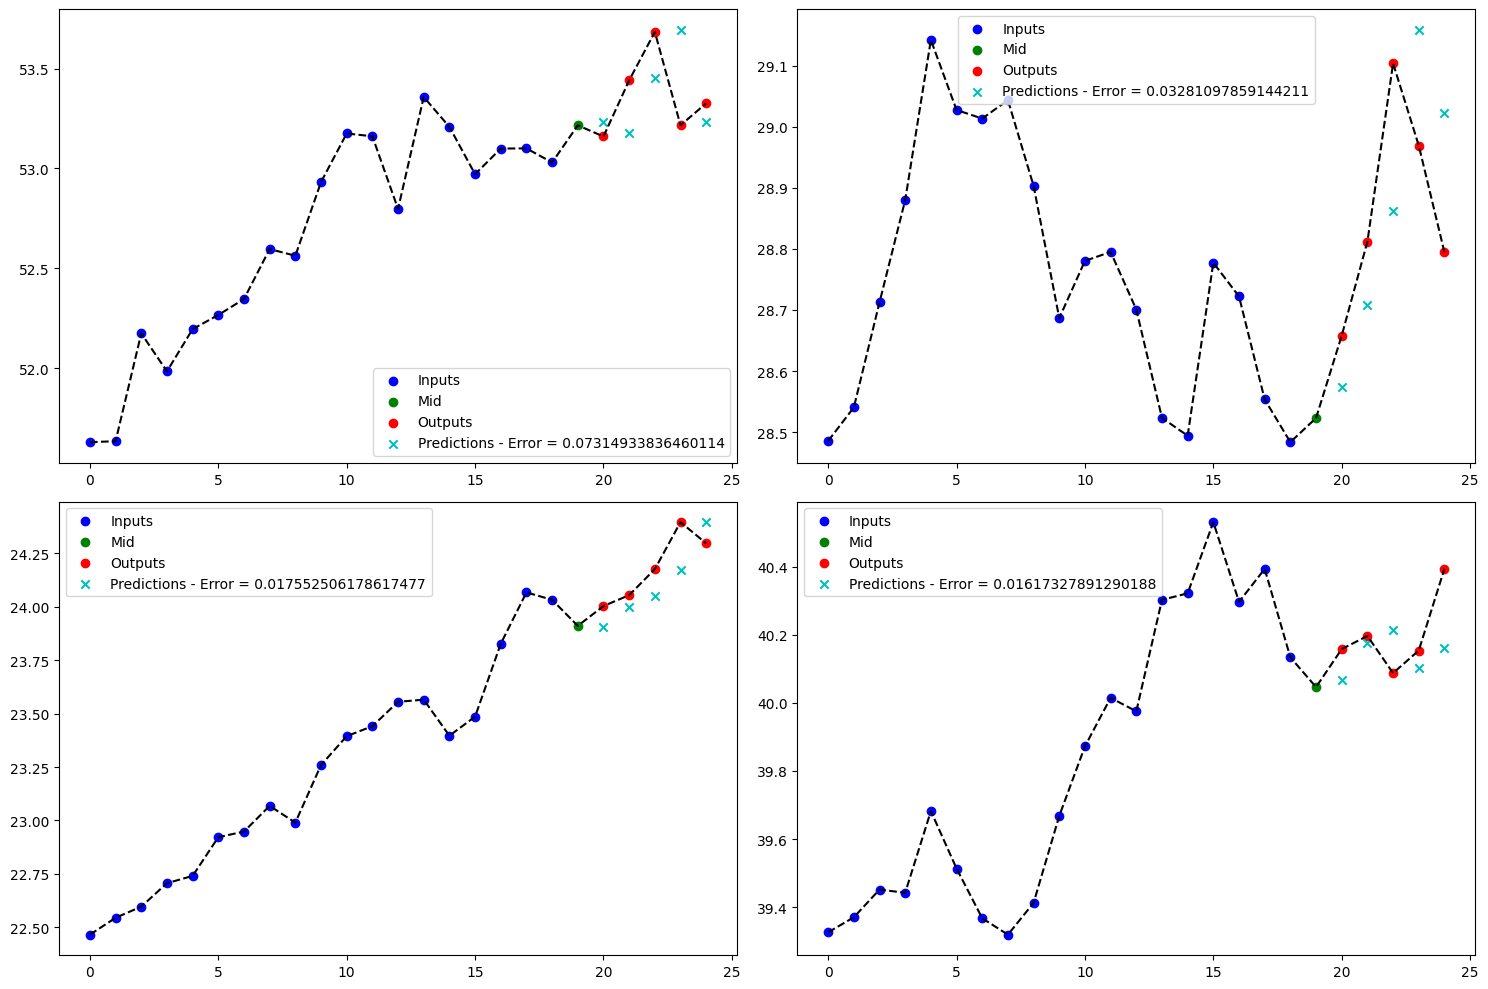

In [67]:
# Reload the model
# (Seeding for reproducibility)
# hidden_size = 25
# seq2seq_model = Seq2Seq(input_size = n_inputs, \
#                         hidden_size = hidden_size, \
#                         output_size = n_outputs).to(device)
# seq2seq_model.load_state_dict(torch.load('seq2seq_model_end.pth'))
# Visualize
visualize_some_predictions(seq2seq_model, pt_dataloader)

## This concludes HW3.

Do not give up, it is a feasible task! If your model does not work, most likely, you are making a mistake in the Encoder model or - most likely - the Decoder model. Take your time to think about the task at hand and the model we should use for that task.